This defines the functions it will use for computing and creates the 
tumble as 2 vectors and a tumble time. 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import colors
from matplotlib import patches
#import colorspace

SEED = 1024  #Any random seed
np.random.seed(SEED)

#Constants for E.coli tumbling
tumble_time_mu = 0.1

#E.coli movement constants
speed = 20         #um/s, speed of E.coli movement
response_time = 0.5 #Able to respond every 0.5 second

#Model constants
start = [0, 0]  #All cells start at [0, 0]
ligand_center = [1500, 1500] #Position of highest concentration
center_exponent, start_exponent = 8, 2 ## THIS MAKES GRADIENT DISPLAY 
origin_to_center = 0 #Distance from start to center, intialized here, will be actually calculated later
saturation_conc = 10 ** 8 #From BNG model

# Calculates Euclidean distance between point a and b
def euclidean_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

# Exponential gradient, the exponent follows a linear relationship with distance to center
def calc_concentration(pos):
    dist = euclidean_distance(pos, ligand_center)
    exponent = (1 - dist / origin_to_center) * (center_exponent - start_exponent) + start_exponent
    if exponent < 5:
        return np.power(10, exponent),exponent
    else:
        return np.power(10, 6),exponent

# Samples the new direction and time of a tumble
# Calculates projection on the Horizontal and Vertical direction for the next move
# No input
# Return the horizontal movement projection (float), the vertical one (float), tumble time (float)
def tumble_move():
    #Sample the new direction unformly from 0 to 2pi, record as a float
    new_dir = np.random.uniform(low = 0.0, high = 2 * math.pi)
        
    projection_h = math.cos(new_dir) #displacement projected on Horizontal direction for next run, float
    projection_v = math.sin(new_dir) #displacement projected on Vertical direction for next run, float
    
    #Length of the tumbling sampled from exponential distribution with mean=0.1, float
    tumble_time = np.random.exponential(tumble_time_mu)
    
    return projection_h, projection_v, tumble_time

this is the pure random walk but it looks kinda jumpy vs the code they used for the chemotactic so i am going to 
change the chemotactic one

In [19]:
def simulate_std_random(num_cells, duration, run_time_expected):
    
    #Takes the shape (num_cells, duration+1, 2)
    #any point [x,y] on the simulated trajectories can be accessed via paths[cell, time]
    paths = np.zeros((num_cells, duration + 1, 2))

    for rep in range(num_cells):
        # Initialize simulation
        t = 0 #record the time elapse
        curr_position = np.array(start) #start at [0, 0] ???
        projection_h, projection_v, tumble_time = tumble_move() #Initialize direction randomly
        past_sec = 0

        while t < duration:
            
            #run
            curr_run_time = np.random.exponential(run_time_expected) #get run duration, float
            #displacement on either direction is calculated as the projection * speed * time
            #update current position by summing old position and displacement
            curr_position = curr_position + np.array([projection_h, projection_v]) * speed * curr_run_time
            
            #tumble
            projection_h, projection_v, tumble_time = tumble_move()
            
            #increment time
            t += (curr_run_time + tumble_time)

            #record position approximate for integer number of second
            curr_sec = int(t)
            for sec in range(past_sec, min(curr_sec, duration) + 1):
                #fill values from last time point to current time point
                paths[rep, sec] = curr_position.copy()
                past_sec= curr_sec
    
    return paths

This is me trying to figure out the chemotactic gradient
Part 1) adjusts run duration in some way I am not too sure but its then
fed into the gradient, I need to see if when i dont change concentration this new function still has an impact on trajectory
Concentrations are set according to model at the top of code

I think it worked well, previously i didnt change run duration so I am going to try to edit it to just include the exponential sampling and get rid of concentration params in the actial chemo simulator 

Got rid of all concentratation dependent operations, sampling from
exponential dist w run_time_expected seems to be the way to go to get
the cells to follow a patern in their random walk 

In [20]:
# Calculate the wait time for next tumbling event
# Input: current concentration (float), past concentration (float), position (array [x, y]), expected run time (float)
# Return: duration of current run (float)
## CHANGED PARAMS OF FUNC
def run_duration(curr_conc, past_conc, position,run_time_expected):
        
    curr_conc = min(curr_conc, saturation_conc) #Can't detect higher concentration if receptors saturates
    past_conc = min(past_conc, saturation_conc)
    change = (past_conc - curr_conc) / (curr_conc+0.0001) #proportion change in concentration, float
    ### SWITCHED PAST AND CURR IN NUMERATOR OF CHANGE AROUND AND NOW IT IS REPPELED BY CONC 
    run_time_expected_adj_conc = run_time_expected * (1 + 10 * change) #adjust based on concentration change, float
    
    if run_time_expected_adj_conc < 0.000001:
        run_time_expected_adj_conc = 0.000001 #positive wait times
    elif run_time_expected_adj_conc > 4 * run_time_expected:
        run_time_expected_adj_conc = 4 * run_time_expected     #the decrease to tumbling frequency is only to a certain extent
    #Sample the duration of current run from exponential distribution, mean=run_time_expected_adj_conc
    curr_run_time = np.random.exponential(run_time_expected_adj_conc)
    
    return curr_run_time

In [21]:
# This function performs simulation
# Input: number of cells to simulate (int), how many seconds (int), the expected run time before tumble (float)
# Return: the simulated trajectories paths: array of shape (num_cells, duration+1, 2)
def simulate_chemotaxis(num_cells, duration, run_time_expected):
    
    #Takes the shape (num_cells, duration+1, 2)
    #any point [x,y] on the simulated trajectories can be accessed via paths[cell, time]
    paths = np.zeros((num_cells, duration + 1, 2))

    for rep in range(num_cells):
        # Initialize simulation
        t = 0 #record the time elapse
        curr_position = np.array(start) #start at [0, 0]
        past_conc = calc_concentration(start)[0] # Conc currently 1
        projection_h, projection_v, tumble_time = tumble_move() #Initialize direction randomly

        while t < duration:
            curr_conc = calc_concentration(curr_position)[0]

            curr_run_time = run_duration(curr_conc, past_conc, curr_position, run_time_expected) #get run duration, float

            # if run time (r) is within the step (s), run for r second and then tumble
            if curr_run_time < response_time: 
                #displacement on either direction is calculated as the projection * speed * time
                #update current position by summing old position and displacement
                curr_position = curr_position + np.array([projection_h, projection_v]) * speed * curr_run_time
                projection_h, projection_v, tumble_time = tumble_move() #tumble
                t += (curr_run_time + tumble_time) #increment time

            # if r > s, run for r; then it will be in the next iteration
            else:
                #displacement on either direction is calculated as the projection * speed * time
                #update current position by summing old position and displacement
                curr_position = curr_position + np.array([projection_h, projection_v]) * speed * response_time
                t += response_time #no tumble here

            #record position approximate for integer number of second
            curr_sec = int(t)
            if curr_sec <= duration:
                #fill values from last time point to current time point
                paths[rep, curr_sec] = curr_position.copy()
                past_conc = curr_conc
    
    return paths

In [24]:
## run_time_expected: Run. The duration of a cell’s run follows an exponential distribution 
#with mean equal to the background run duration run_time_expected.
duration = 800   #seconds, duration of the simulation
num_cells = 3
run_time_expected = 1.0
origin_to_center = euclidean_distance(start,ligand_center) #Update the global constant so we dont get division by 0

#make an array cos i cant be asked to change plotting set up 
paths_chem =  simulate_chemotaxis(num_cells, duration, run_time_expected)
paths_rand = simulate_std_random(num_cells, duration, run_time_expected)
paths = np.array([paths_rand, paths_chem])


ValueError: math domain error

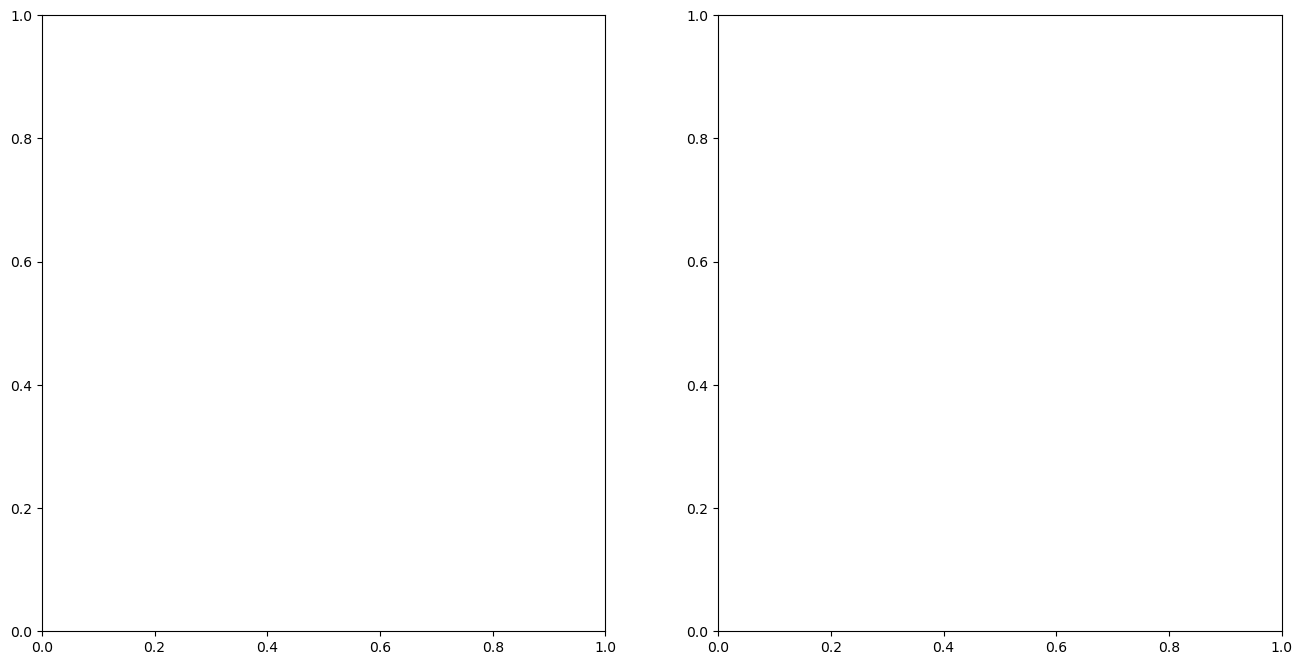

In [25]:
## Plotting THIS IS MY OG CODE
#Below are all for plotting purposes
methods = ["Pure random walk", "More accurate random walk"]
fig, ax = plt.subplots(1, 2, figsize = (16, 8)) #1*2 subplots, size 16*8

#First set color map
mycolor = [[256, 256, 256], [256, 255, 254], [256, 253, 250], [256, 250, 240], [255, 236, 209], [255, 218, 185], [251, 196, 171], [248, 173, 157], [244, 151, 142], [240, 128, 128]] #from coolors：）
for i in mycolor:
    for j in range(len(i)):
        i[j] *= (1/256)
cmap_color = colors.LinearSegmentedColormap.from_list('my_list', mycolor) #Linearly segment these colors to create a continuous color map

#Store the concentrations for each integer position in a matrix
conc_matrix = np.zeros((4000, 4000)) #we will display from [-1000, -1000] to [3000, 3000]
for i in range(4000):
    for j in range(4000):
         conc_matrix[i][j] = calc_concentration([i - 1000, j - 1000])[1]*math.log(10)
##WORKS UP TO HERE
#Repeat for the two strategies
for m in range(2):
    #Simulate the gradient distribution, plot as a heatmap
    ax[m].imshow(conc_matrix.T, cmap=cmap_color, interpolation='nearest', extent = [-1000, 3000, -1000, 3000], origin = 'lower')

    #Plot simulation results
    time_frac = 1.0 / duration
    #Plot the trajectories. Time progress: dark -> colorful
    for t in range(duration):
        ax[m].plot(paths[m,0,t,0], paths[m,0,t,1], 'o', markersize = 1, color = (0.2 * time_frac * t, 0.85 * time_frac * t, 0.8 * time_frac * t))
        ax[m].plot(paths[m,1,t,0], paths[m,1,t,1], 'o', markersize = 1, color = (0.85 * time_frac * t, 0.2 * time_frac * t, 0.9 * time_frac * t))
        ax[m].plot(paths[m,2,t,0], paths[m,2,t,1], 'o', markersize = 1, color = (0.4 * time_frac * t, 0.85 * time_frac * t, 0.1 * time_frac * t))
    ax[m].plot(start[0], start[1], 'ko', markersize = 8) #Mark the starting point [0, 0]
    for i in range(num_cells):
        ax[m].plot(paths[m,i,-1,0], paths[m,i,-1,1], 'ro', markersize = 8) #Mark the terminal points for each cell
    #ax[m].plot(1500, 1500, 'bX', markersize = 8) #Mark the highest concentration point [1500, 1500]

    ax[m].set_title("{}\n Average tumble every 1 s".format(methods[m]), x = 0.5, y = 0.87)
    ax[m].set_xlim(-1000, 3000)
    ax[m].set_ylim(-1000, 3000)
    ax[m].set_xlabel("poisiton in μm")
    ax[m].set_ylabel("poisiton in μm")

fig.tight_layout()

plt.show()

In [17]:
calc_concentration(start)

1000000

In [ ]:
curr_position = np.array(start)
calc_concentration(curr_position)